In [2]:
!pip install lungmask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Загурзка DICOM file 
!unzip "/content/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006.zip"

In [96]:
# Загрузка модели 
!unzip "/content/genrator.zip"

Archive:  /content/genrator.zip
  inflating: genrator.h5             
  inflating: genrator.json           


In [3]:
from google.colab.patches import cv2_imshow

In [4]:
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from lungmask import mask
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json


In [5]:
# Чтение DICOM folder 
def load_dicom(file_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(file_path)
    reader.SetFileNames(dicom_names)

    image = reader.Execute()
    return image

Нормальзация данных и перевод в 3-х каннальное пространство 

In [6]:
def normalize(img:np.array) -> np.array:
    min_in = np.min(img)
    max_in = np.max(img)
    return (img - min_in) / (max_in - min_in + 1e-8)

In [7]:
def get_rgb_img(cub_array: np.array)-> np.array:

    d ,h , w = cub_array.shape 
    print(d ,h, w)
    for i in range(d):
        cub_array[i,:,:] = normalize(cub_array[i,:,:])*255
    image_3d = np.stack((cub_array,cub_array,cub_array),axis=3) # получение 3-х канального изображения
    return image_3d

ЧТЕНИЕ DICOM

In [8]:
path_file = '/content/1.2.643.5.1.13.13.12.2.77.8252.00001215001001020205001001151006/1.2.643.5.1.13.13.12.2.77.8252.02101308110405141311140509080204'

In [9]:
image = load_dicom(path_file) # Чтение 
image_array = sitk.GetArrayFromImage(image) # перевод в массив

In [10]:
image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f7c5d6f9630> >

In [11]:
im = get_rgb_img(image_array)  # получение 3-х канальное изображение 

451 512 512


In [12]:
im.shape

(451, 512, 512, 3)

ПРЕДПРОСМОТР

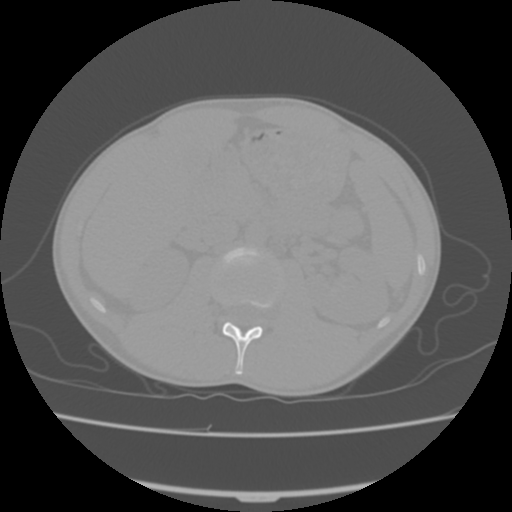

In [13]:
cv2_imshow(normalize(image_array[0,:,:])*255)

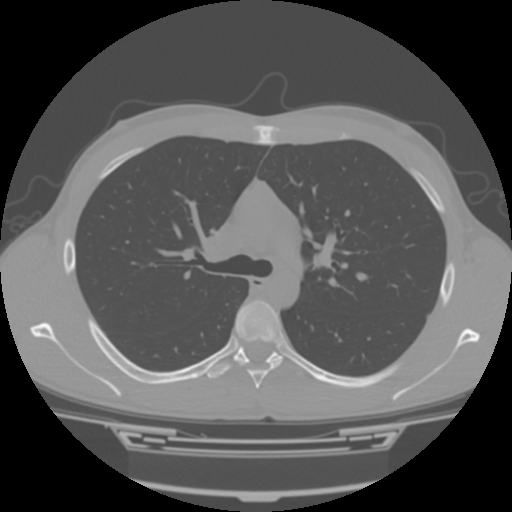

In [14]:
cv2_imshow(im[300,:,:,:])

Сегментация легких и прекраска маски в зеленный цвет

In [15]:
# сегментация легких 
def segmentation_lung(SimpleITK_image):
    model = mask.get_model('unet', "LTRCLobes" )
    segmentation = mask.apply(SimpleITK_image, model)
    return segmentation

In [16]:
def get_green_mask(mask):
    d ,h , w = mask.shape 
    print(d ,h, w)
    for i in range(d):
        
        ones_array = np.zeros((d,512,512))
    image_3d = np.stack((ones_array,mask*255,ones_array),axis=3) # получение 3-х канального изображения
    return image_3d


Генерация маски

In [17]:
#  сгененрированные маскм данные 
path_generat_mask = "/content/study_0255_mask.nii.gz"
#  считаю их сделаю 3-х канальными и зеленного цвета 
mask_items = sitk.ReadImage(path_generat_mask)
mask_array = sitk.GetArrayFromImage(mask_items)

# маска в 3-х каналах и зеленого цвета
ones = np.zeros((14,512,512,3)) 
mask_array_1 = get_green_mask(mask_array)
print(mask_array_1.shape)
print(ones.shape)
mask_array_1 = np.concatenate((ones, mask_array_1,mask_array_1,mask_array_1,mask_array_1), axis = 0)
mask_array_1 = np.concatenate((mask_array_1,mask_array_1,mask_array_1), axis = 0)

38 512 512
(38, 512, 512, 3)
(14, 512, 512, 3)


Предпросмотр маски 


In [18]:
mask_array_1.shape

(498, 512, 512, 3)

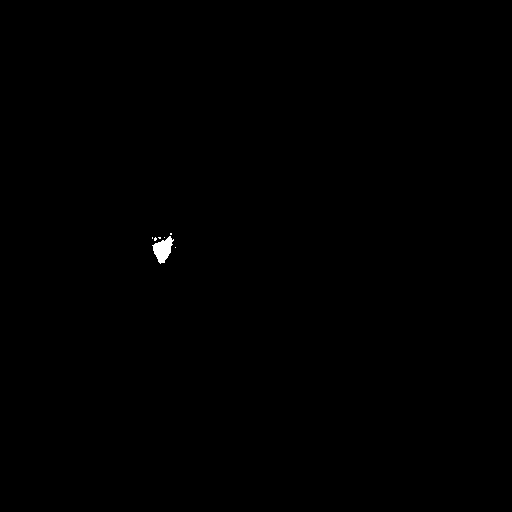

In [19]:
cv2_imshow(mask_array[30,:,:]*255)

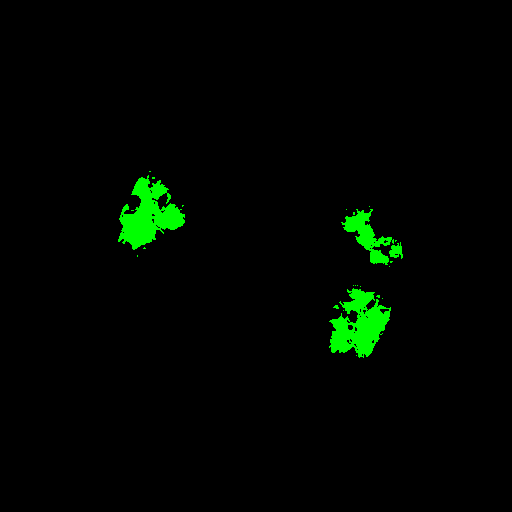

In [20]:
cv2_imshow(mask_array_1[310,:,:,:])

In [21]:
seg = segmentation_lung(image)

100%|██████████| 210/210 [00:12<00:00, 17.20it/s]


In [26]:
seg.shape

(451, 512, 512)

In [23]:
# план наложить сначала болячку, потом вырезать легкие чтобы исключить выход за пределы 

ВЫРЕЗАНИЕ легких и наложение масок ковида 

In [27]:
def cut_image_by_mask(image, seg_lung, seg_covid):
    n, h, w, c = image.shape
    # пустое изображение по 
    return_array = np.zeros((n,h,w,c))
    type_ = image.dtype
    seg_covid = seg_covid.astype(type_)
    seg_lung = seg_lung.astype(np.uint8)
    # Наложение маски ковида 
    for i in range(n):
        lungs_image1 = image[i,:,:,:].copy()
        lungs_image[np.repeat(seg_covid[:, :, 1][..., np.newaxis], 3, axis=2) > 0] = 0
        return_array[i,:,:,:] =  cv2.add(image[i,:,:,:], seg_covid[i,:,:,:])
    # вырезание легких с ковидом 
    for i in range(n):
        
        return_array[i,:,:,:] =  cv2.bitwise_and(return_array[i,:,:,:], return_array[i,:,:,:],mask = seg_lung[i,:,:])
    return return_array

In [ ]:
result = cut_image_by_mask(im, seg, mask_array_1)

Предпросмотр

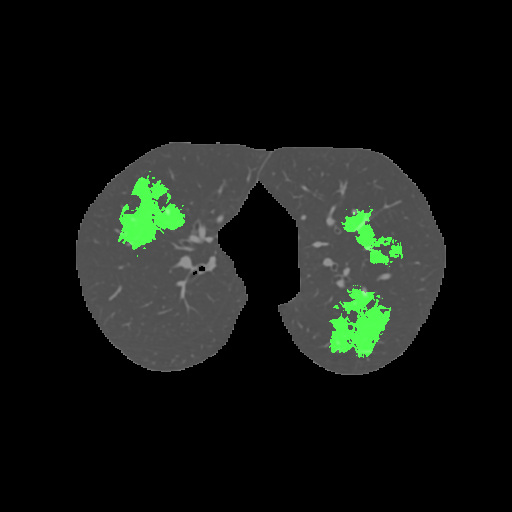

In [381]:
cv2_imshow(result[310,:,:,:])

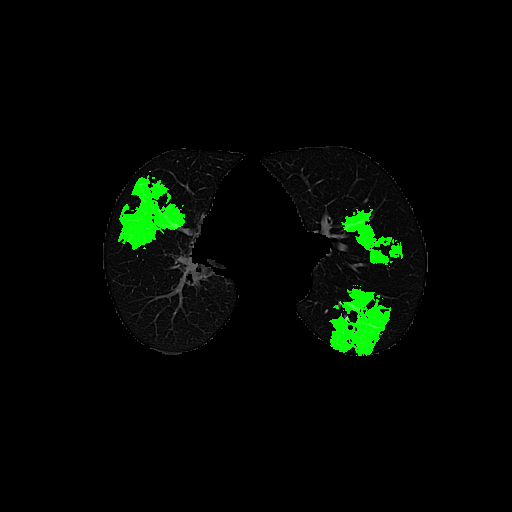

In [257]:
cv2_imshow(result[30,:,:,:])

Загрузка модели cGAN

In [268]:
# определение модели 
model_h5 = "/content/genrator_1.h5"
model_json = "/content/genrator_1.json"

In [269]:
with open(model_json, 'r') as f:
    loaded_model = model_from_json(f.read())
   
loaded_model.load_weights(model_h5)


Предобработка изображений для загрузки в модель

In [245]:
def pred(model,image):
    prediction = model(image, training=True)
    return  ((prediction[0,:,:,:]* 0.5 + 0.5)*255).numpy()

In [197]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image
    
# Normalizing the images to [-1, 1]
def normalize_nn(input_image, ):
    input_image = (input_image / 127.5) - 1
    return input_image

In [205]:
def load_image(input_image):
    
    input_image = normalize_nn(input_image)
    return input_image

In [265]:
img = load_image(result[30,:,:,:])
img = np.expand_dims(img, axis=0)

Prediction


In [270]:
pred_image = pred(loaded_model,img)

In [293]:
pred_image.shape

(512, 512, 3)

In [312]:
# Замена маски на ковид
def get_covid_for_mask(image):
    n, h, w, c = image.shape
    return_array = np.zeros((n, h, w, c))
    for i in range(n):
        # предобработка 
        load_im = load_image(image[i,:,:,:])
        load_im = np.expand_dims(load_im, axis=0)
        # предсказание 
        pred_image = pred(loaded_model,load_im)

        return_array[i,:,:,:] = pred_image
    return return_array

In [319]:
mask_with_covid = get_covid_for_mask(result)

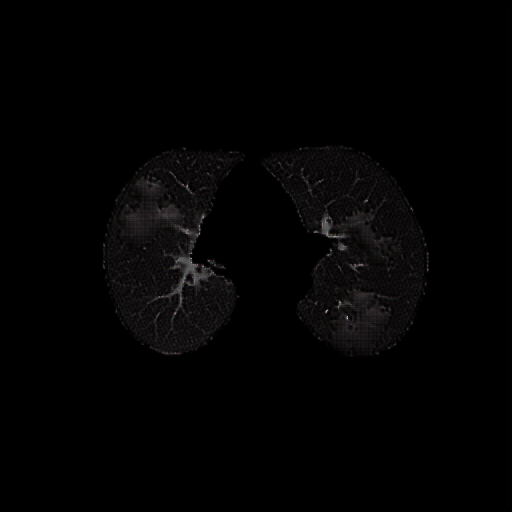

In [314]:
cv2_imshow(pred_image)

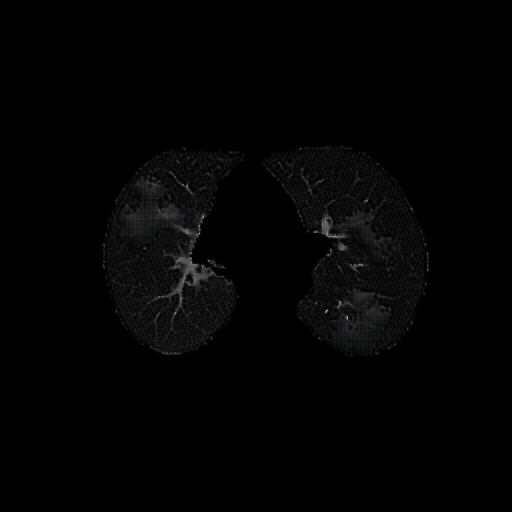

In [320]:
cv2_imshow(mask_with_covid[30,:,:,:])

In [321]:
def get_result_cub(image, mask_covid):
    n, h, w, c = image.shape
    return_array = np.zeros((n, h, w, c))
    type_ = image.dtype
    mask_covid = mask_covid.astype(type_)
    for i in range(n):
        
        return_array[i,:,:,:] = cv2.add(image[i,:,:,:], mask_covid[i,:,:,:])
    return return_array

In [322]:
result_3d = get_result_cub(im, mask_with_covid)

In [323]:
n,_,_,_ = result.shape

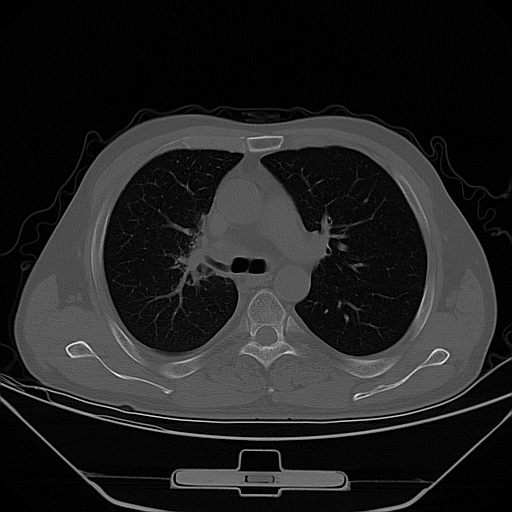

In [325]:
cv2_imshow(im[30,:,:,:])

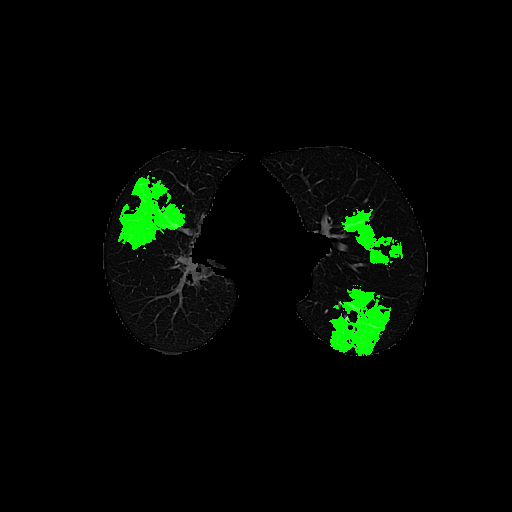

In [324]:

cv2_imshow(result[30,:,:,:])

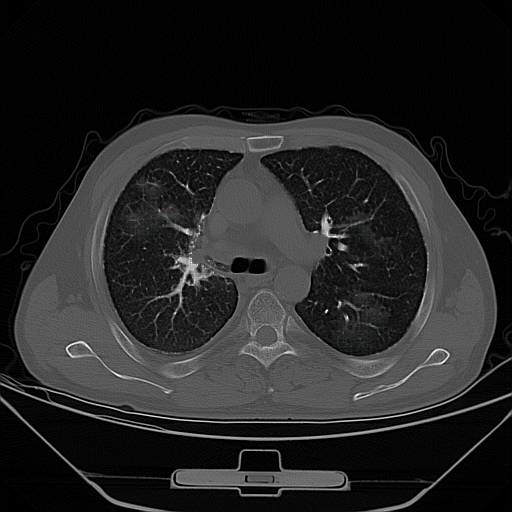

In [326]:
cv2_imshow(result_3d[30,:,:,:])

In [ ]:
for i in range(n):
    cv2_imshow(result[i,:,:,:])

In [340]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
org = (25, 20)
  
# fontScale
fontScale = 1
   
# Blue color in BGR
color = (0, 0, 255)

In [342]:
for i in range(n):
    text = "Covid-19; 10-20 mm"
    img_ret = np.hstack((im[i,:,:,:], result_3d[i,:,:,:]))
    img_ret = cv2.putText(img_ret, text, org, font, 
                   fontScale, color, 1, cv2.LINE_AA)
    cv2.imwrite(f"/content/images/{i}.jpg",img_ret)